<a href="https://colab.research.google.com/github/timrocar/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [104]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [105]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [106]:
## Writing a wrangle function 
import numpy as np

def wrangle(X):
  # Make a copy
  X = X.copy()

  # Add target feature
  if 'status_group' in X.columns:
    X['needs_repair'] = X['status_group'].apply(lambda x: 0 if x =='functional' else 1)
    X.drop('status_group', axis=1, inplace=True)


  # convert to date_time
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  X['year_recorded'] = X['date_recorded'].dt.year  

  # Replace bad lat. measurements with 0 to then replace with NaN
  X['latitude'] = X['latitude'].replace  (-2e-08, 0)

  # When columns have zeros and shouldn't, they are like null values
  cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.NaN)
        
  # Drop high cardinality
  hc_cols = [col for col in X.describe(include='object'). columns
             if X[col].nunique() > 100]



  # Drop high cards, our repeated column, num_private, and recorded_by
  X = X.drop(['quantity_group', 'recorded_by', 'id', 'date_recorded', 'num_private',
              'scheme_name', 'extraction_type_group', 'extraction_type_class',
              'management_group', 'payment_type', 'quantity_group', 'source_type',
              'source_class', 'waterpoint_type_group'] + hc_cols, axis=1)

  return X

In [107]:
train = wrangle(train)
test = wrangle(test)

In [108]:
# train-validation split 
from sklearn.model_selection import train_test_split
target = 'needs_repair'

train, val = train_test_split(train, test_size=len(test),
                              stratify=train[target], random_state=73)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test


In [109]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5430709115936238


In [110]:
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [117]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report

In [118]:
  model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=17, max_leaf_nodes=3770, n_estimators=100)
)

# Fit on train, score on val
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Check Metrics
print('Training Accuracy', accuracy_score(y_train, model.predict(X_train)))
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Training Accuracy 0.9438302029217175
Validation Accuracy 0.8306170775874078


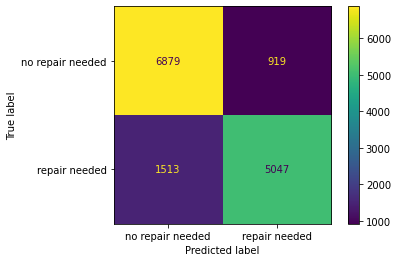

In [119]:
plot_confusion_matrix(model, X_val, y_val,
                      values_format='.0f',
                      display_labels=['no repair needed', 'repair needed'])